<a href="https://colab.research.google.com/github/rithikkulkarni/ALDA-Course-Project/blob/main/basic_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # Example classifier
from sklearn.linear_model import LogisticRegression # Alternative classifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [27]:
# --- Configuration ---
CSV_FILE_PATH = 'datasets/labeled_stock_tweets_with_historical_prices.csv'  # <--- CHANGE THIS to your CSV file path
TARGET_COLUMN = 'stock_label'
# TEXT_FEATURE = 'Cleaned_Tweet'
NUMERICAL_FEATURES = ['one_day_price', 'two_day_price', 'three_day_price', 'historical_price'
                       , 'Label'
                      ]
# CATEGORICAL_FEATURES = ['Stock Name'] # Assuming 'Stock Name' is the primary identifier
# You could add 'Company Name' here too, but it might be redundant if Stock Name is unique
# CATEGORICAL_FEATURES = ['Stock Name', 'Company Name']

TEST_SIZE = 0.2  # 20% of data for testing
RANDOM_STATE = 42 # For reproducibility

In [28]:

df = pd.read_csv('https://raw.githubusercontent.com/rithikkulkarni/ALDA-Course-Project/refs/heads/main/datasets/labeled_stock_tweets_with_historical_prices.csv')
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)  # Shuffle the DataFrame
print(f"Successfully loaded data. Shape: {df.shape}")
print("\nSample data:")
print(df.head())
print(f"\nTarget variable distribution:\n{df[TARGET_COLUMN].value_counts(normalize=True)}")
print(df['stock_label'].value_counts())
df.head(1)

Successfully loaded data. Shape: (20934, 11)

Sample data:
         Date                                              Tweet Stock Name  \
0  2022-07-28  @TSM_Albralelie I am sure you'll find somethin...        TSM   
1  2022-04-14            The factories are firing back on - $NIO        NIO   
2  2022-05-31  watchlist for tomorrow: | $SPX | $CRM | $KHC |...        CRM   
3  2022-08-12  Very interesting data from Jefferies showing C...        AMD   
4  2022-07-22  Argus analyst Bill Selesky lowered the price t...       TSLA   

                                        Company Name  Label  stock_label  \
0  Taiwan Semiconductor Manufacturing Company Lim...      1            0   
1                                           NIO Inc.     -1           -1   
2                                   Salesforce, Inc.      0            1   
3                       Advanced Micro Devices, Inc.      1            0   
4                                        Tesla, Inc.      0            0   

   pct_ch

,Date,Tweet,Stock Name,Company Name,Label,stock_label,pct_change,one_day_price,two_day_price,three_day_price,historical_price
0,2022-07-28,@TSM_Albralelie I am sure you'll find somethin...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,1,0,-0.146711,83.48,80.42,82.22,78.85


In [29]:
# This cell gets an equal sample from each label, so we end up with a valid accuracy that isn't inflated from too many of one label

# Find the minimum class count across the classes
min_count = df['Label'].value_counts().min()

# Create a balanced dataframe by sampling min_count instances from each group
df = df.groupby('Label').sample(n=min_count, random_state=42).reset_index(drop=True)

# Sanity check for class balance
print(df['Label'].value_counts())

Label
-1    6617
 0    6617
 1    6617
Name: count, dtype: int64


In [30]:
# --- 2. Define Features (X) and Target (y) ---
X = df[NUMERICAL_FEATURES]
y = df[TARGET_COLUMN]

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y # Important for classification, especially if classes are imbalanced
)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 15880
Test set size: 3971


In [31]:
# --- 5. Choose and Define the Model ---
# Using RandomForestClassifier as an example. It often works well with mixed data.
# You can adjust n_estimators, max_depth, etc., or try other models.
# class_weight='balanced' can help if your classes (-1, 0, 1) are imbalanced.
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1)

# Alternative: Logistic Regression (often faster, good baseline)
# model = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight='balanced', random_state=RANDOM_STATE)

print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")

# --- 7. Make Predictions ---
print("\nMaking predictions on the test set...")
y_pred = model.predict(X_test)

# --- 8. Evaluate the Model ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
# Use labels=[-1, 0, 1] to ensure all classes are shown even if one is missing in predictions
# zero_division=0 handles cases where precision/recall might be zero for a class
print(classification_report(y_test, y_pred, labels=[-1, 0, 1], target_names=['Down (-1)', 'Neutral (0)', 'Up (1)'], zero_division=0))

print("\nConfusion Matrix:")
# Rows: Actual, Columns: Predicted
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
print(pd.DataFrame(cm, index=['Actual Down', 'Actual Neutral', 'Actual Up'],
                   columns=['Predicted Down', 'Predicted Neutral', 'Predicted Up']))


Training the model...
Model training complete.

Making predictions on the test set...

--- Model Evaluation ---
Accuracy: 0.9673

Classification Report:
              precision    recall  f1-score   support

   Down (-1)       0.97      0.96      0.97      1187
 Neutral (0)       0.96      0.97      0.97      1546
      Up (1)       0.98      0.97      0.97      1238

    accuracy                           0.97      3971
   macro avg       0.97      0.97      0.97      3971
weighted avg       0.97      0.97      0.97      3971


Confusion Matrix:
                Predicted Down  Predicted Neutral  Predicted Up
Actual Down               1144                 34             9
Actual Neutral              25               1502            19
Actual Up                   14                 29          1195


Mean Squared Error: 0.19958088996603862

Classification Report:
              precision    recall  f1-score   support

          -1       0.98      0.99      0.98      2009
           0       0.58      0.33      0.42        21
           1       0.98      0.98      0.98      1941

    accuracy                           0.98      3971
   macro avg       0.85      0.77      0.80      3971
weighted avg       0.98      0.98      0.98      3971



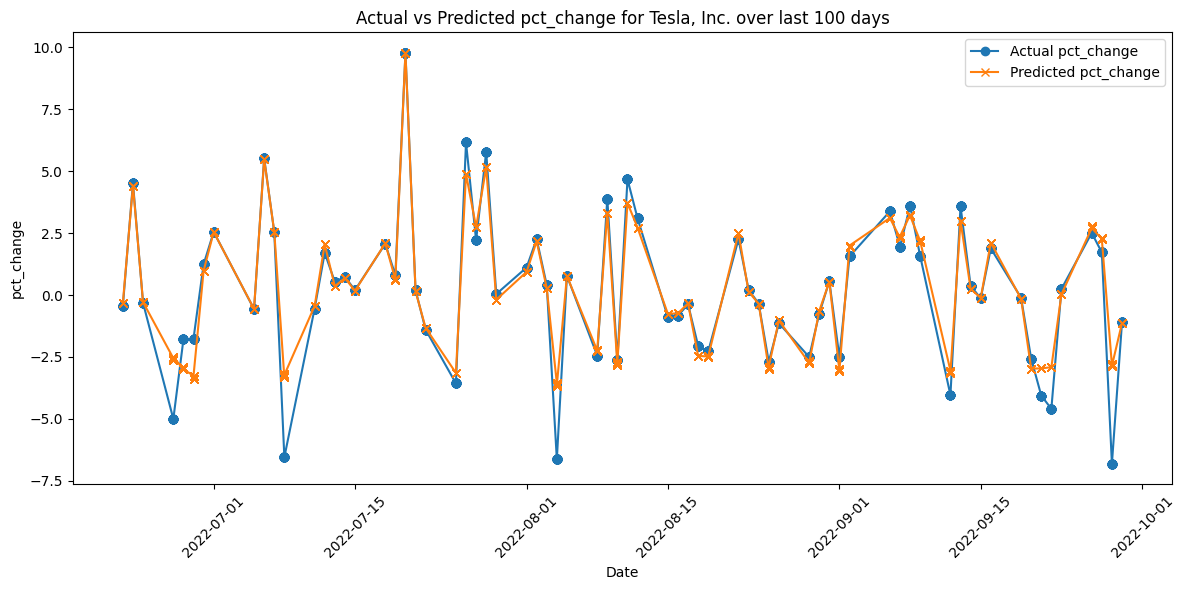

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, classification_report

# ---------------------------
# 1. Data Preprocessing and Model Training
# ---------------------------
# Assume df contains:
# Date, Tweet, Stock Name, Company Name, Label, stock_label, pct_change,
# one_day_price, two_day_price, three_day_price, historical_price

# Preprocessing: Drop Date and Tweet columns (advanced processing can be added later)
df_model = df.drop(columns=['Date', 'Tweet'])

# One-hot encode categorical features
df_model = pd.get_dummies(df_model, columns=['Stock Name', 'Company Name', 'Label', 'stock_label'], drop_first=True)

# Define features (X) and target (y)
X = df_model.drop(columns=['pct_change'])
y = df_model['pct_change']

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# ---------------------------
# 2. Classification Report (after discretizing continuous pct_change)
# ---------------------------
# Define a helper function to convert pct_change to discrete labels.
def label_movement(pct):
    if pct > 0.015:
        return 1
    elif pct < -0.015:
        return -1
    else:
        return 0

# Convert both actual and predicted values to discrete labels
y_test_class = y_test.apply(label_movement)
y_pred_class = pd.Series(y_pred).apply(label_movement)

print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

# ---------------------------
# 3. Graph: Actual vs. Predicted pct_change over Time for a Given Company
# ---------------------------
# Set parameters: specify company and number of days (n) for plotting
company_name = "Tesla, Inc."  # Replace with the desired company name (should match entries in 'Company Name')
n = 100  # Number of days to plot

# Filter the original df for the selected company
df_company = df[df['Company Name'] == company_name].copy()

# Ensure Date is in datetime format and sort by Date
df_company['Date'] = pd.to_datetime(df_company['Date'])
df_company.sort_values('Date', inplace=True)

# Instead of taking the last n rows, filter the data to strictly include the last n days
end_date = df_company['Date'].max()
start_date = end_date - pd.Timedelta(days=n-1)
df_plot = df_company[(df_company['Date'] >= start_date) & (df_company['Date'] <= end_date)]

# Preprocess the company's data similarly to training data:
# Drop Date and Tweet columns
df_model_company = df_plot.drop(columns=['Date', 'Tweet'])

# One-hot encode the categorical features.
df_model_company = pd.get_dummies(df_model_company, columns=['Stock Name', 'Company Name', 'Label', 'stock_label'], drop_first=True)

# IMPORTANT: Ensure the feature columns align with the training data.
# Reindex the columns of X for the company to match X_train's columns, filling missing columns with zeros.
X_company = df_model_company.drop(columns=['pct_change'])
X_company = X_company.reindex(columns=X_train.columns, fill_value=0)

# Actual pct_change values for the company data
y_company_actual = df_model_company['pct_change']

# Predict pct_change using the trained model
y_company_pred = model.predict(X_company)

# Plot the actual vs predicted pct_change over the selected time period
plt.figure(figsize=(12, 6))
plt.plot(df_plot['Date'], y_company_actual, marker='o', label='Actual pct_change')
plt.plot(df_plot['Date'], y_company_pred, marker='x', label='Predicted pct_change')
plt.xlabel('Date')
plt.ylabel('pct_change')
plt.title(f'Actual vs Predicted pct_change for {company_name} over last {n} days')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
